In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import schwinger,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve

In [2]:
N=1
g=1
a=8
theta=np.pi
m=5
H,sx,sy,sz=schwinger(N=N,g=g,a=a,theta=theta,m=m)

In [3]:
H=H

In [4]:
Q=sx[-1]+1.1*sy[-1]+0.9*sz[-1] ## take a look at the berlin guys paper to see if this is a bad coupling operator

In [5]:
E01=1#H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
w0=0.5*a
gamma=w0/2
print(2*w0>gamma)
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)
lam

True


1.9679896712654306

In [6]:
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)
rho0=psi0*psi0.dag()
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)

In [7]:
bath = heom.UnderDampedBath(
        Q=Q,
        lam=lam, gamma=gamma, w0=w0, T=0, Nk=5) # fix runtime warning
cfiitter2 = heom.CorrelationFitter(
    Q, 0, tfit, bath.correlation_function)
bath1, fit2info = cfiitter2.get_fit(Ni=1, Nr=2)
# notice one mode is also a pretty good approximation
print(fit2info['summary'])

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:925: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om + 1.0j * Gamma) / 2)),
/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:927: RuntimeWarning: invalid value encountered in scalar divide
  * (1 / np.tanh(beta * (Om - 1.0j * Gamma) / 2)),


Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-9.14e-02 |-3.54e+00 |1.41e-22                              | 1         |-5.00e-01 |-1.00e+00 |3.87e+00                              
 2         | 5.16e-01 |-1.02e+00 |3.86e+00                              |                                                                        
                                                                        |A  normalized RM

In [8]:
times2 = np.linspace(0,50,100)
cvis = bath.correlation_function(times2)

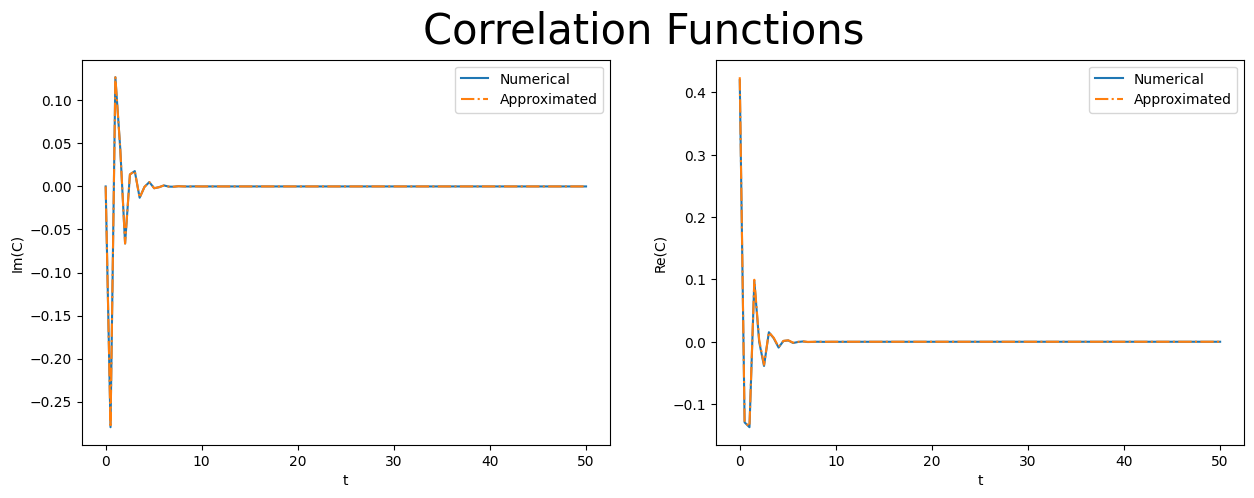

In [9]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath1.correlation_function_approx(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [10]:
solver = heom.HEOMSolver(H,
                          [bath1], max_depth=5, options={"atol": 1e-14})
result = solver.run(rho0, times)

10.1%. Run time:   0.29s. Est. time left: 00:00:00:02
20.2%. Run time:   0.56s. Est. time left: 00:00:00:02
30.3%. Run time:   0.82s. Est. time left: 00:00:00:01
40.4%. Run time:   1.08s. Est. time left: 00:00:00:01
50.5%. Run time:   1.36s. Est. time left: 00:00:00:01
60.6%. Run time:   1.65s. Est. time left: 00:00:00:01
70.7%. Run time:   1.93s. Est. time left: 00:00:00:00
80.8%. Run time:   2.21s. Est. time left: 00:00:00:00
90.9%. Run time:   2.47s. Est. time left: 00:00:00:00
100.0%. Run time:   2.71s. Est. time left: 00:00:00:00
Total run time:   2.71s


In [11]:
cum = csolve(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4, cython=False)

result_cum = cum.evolution(rho0)

result_cum = rotation(result_cum, H, times)

Calculating Integrals ...: 100%|███████████████| 9/9 [00:00<00:00,  9.30it/s]
Calculating time independent matrices...: 100%|█| 9/9 [00:00<00:00, 2193.55it
Calculating time dependent generators: 100%|█| 9/9 [00:00<00:00, 3139.45it/s]
Computing Exponential of Generators . . . .: 100%|█| 100/100 [00:00<00:00, 36


In [12]:
a_ops = [[Q, bath.power_spectrum]]
resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14}, sec_cutoff=-1)

a_ops = [[Q, bath.power_spectrum]]
resultBR2 = brmesolve(H, rho0, times, a_ops=a_ops, options={
    "atol": 1e-14})

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-2.06e-02 |-1.13e+00 |4.00e-16                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.70e-02 |-5.42e+00 |6.79e-05                              |                                                                        
                                                                        |A  normalized RM

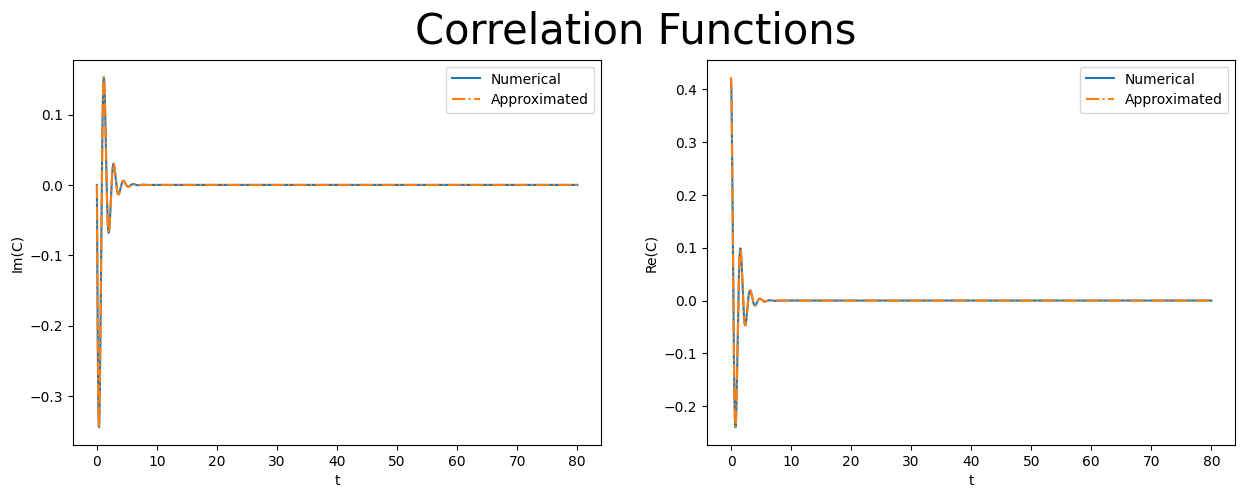

In [13]:
Ncutoff=3
modes=2
bathu = zero_temp_bath(Q, tfit, lam, gamma, w0, N=modes)
example = pseudomode(Hsys=H, Q=Q, bath=bathu)
print(bathu.finfo["summary"])
cvis2 = bathu.correlation_function
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(tfit, np.imag(cvis2),label="Numerical")
axs[0].plot(tfit, np.imag(bathu.bath.correlation_function_approx(tfit))+np.imag(bathu.C0(tfit, lam, gamma, w0)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(tfit, np.real(cvis2),label="Numerical")
axs[1].plot(tfit, np.real(bathu.bath.correlation_function_approx(tfit)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [14]:
# ans = example.evolution(rho0, Ncutoff, times, options={
#                         "atol": 1e-14, "normalize_output": False, "store_states": True})
# ans = [i.ptrace(range(N))for i in ans.states]

In [15]:
from nmm import redfield

In [16]:
bath.bose=None
red = redfield.redfield(
    Hsys=H, t=times, baths=[bath],
    Qs=[Q],
    eps=1e-4,matsubara=False)

result_red = red.evolution(rho0)


Started interpolation


In [17]:
result_red=[Qobj(i) for i in result_red]
for i in result_red:
    i.dims=H.dims
#result_red = rotation(result_red, H, times)

In [18]:
result_red = rotation(result_red, H, times)

In [19]:
results=[result,result_cum,resultBR,resultBR2,result_red]

In [20]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Redfield"]
    style=["solid","solid","dashed","dashdot",'dashed','solid']
    for k,i in enumerate(states[1:],1):
        if "Bloch" in  labels[k]:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        else:
            try:
                sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
            except:
                sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

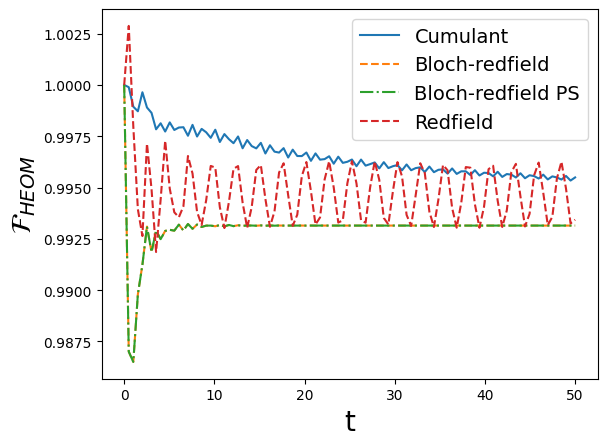

In [21]:
plot_fidelities(results,H,times)

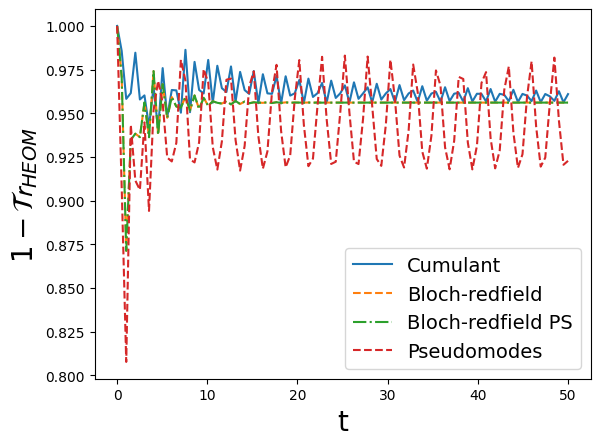

In [22]:
plot_trd(results,H,times)

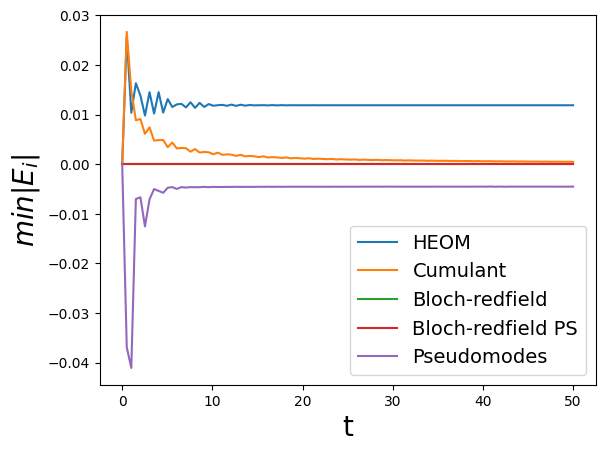

In [23]:
plot_positivity(results,H,times)

In [24]:
def plot_positivity(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Bloch-redfield PS","Pseudomodes","Redfield"]
    for k,i in enumerate(states):
        try:
            sdd=np.array([np.min(i.states[j].eigenenergies()) for j in range(len(times))])
        except:
            sdd=np.array([np.min(i[j].eigenenergies())  for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k])
   # plt.ylim(-1e-3,0.001)
    plt.legend(fontsize=14)
    plt.ylabel(r"$min |E_i|$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

In [25]:
from qutip import qsave

In [26]:
#qsave(results,f"N={N}_schwinger_{lam}_nocheating_seems_hard")

In [27]:
import numpy as np
from scipy.linalg import expm
# compute the Bloch-Redfield tensor in the Hamiltonian's basis
def BR_tensor(H, a_ops, secular = True, secular_cut_off = 0.01):
    dim = len(H) # dimension
    evals,ekets = np.linalg.eig(H) # HS's basis
    # sort basis
    _zipped = list(zip(evals, range(len(evals))))
    _zipped.sort()
    evals, perm = list(zip(*_zipped))
    ekets = np.array([ekets[:, k] for k in perm])
    evals = np.array(evals)
    # coupling operators in H basis
    a_ops_S = [[ekets.conjugate()@a@ekets.T,nps] for a,nps in a_ops] 
    # Bohr frequencies (w_ab)
    indices = [(a,b) for a in range(dim) for b in range(dim)]
    BohrF = np.sort(np.array([evals[a]-evals[b] for a in range(dim) for b in range(dim)]))
    # construct empty R
    R = np.zeros((dim**2,dim**2),dtype = complex) 
    for j,(a,b) in enumerate(indices): # loop over indices
        for k,(c,d) in enumerate(indices): # loop over indices
            # unitary part
            R[j,k] += -1j * (a==c)*(b==d)*(evals[a]-evals[b])
            for a_op,nps in a_ops_S: # loop over uncorrelated a_ops
                gmax = np.max([bath.power_spectrum(f) for f in BohrF]) # largest rate for secular approximation
                A = a_op # coupling operator
                # secular approximation test
                if secular is True and abs(evals[a]-evals[b]-evals[c]+evals[d]) > gmax*secular_cut_off:
                    pass
                else:      
                    # non-unitary part
                    R[j,k] += - 1/2 * ((b==d)*np.sum([A[a,n]*A[n,c]*nps(evals[c]-evals[n])  
                                                      for n in range(dim)])
                                                     -A[a,c]*A[d,b]*nps(evals[c]-evals[a]) +
                                       (a==c)*np.sum([A[d,n]*A[n,b]*nps(evals[d]-evals[n])  
                                                      for n in range(dim)])
                                                     -A[a,c]*A[d,b]*nps(evals[d]-evals[b]))
    return R

In [28]:
# Hamiltonian eigendecomposition
evals,ekets = np.linalg.eig(H.full()) # HS's basis
# sort basis
_zipped = list(zip(evals, range(len(evals))))
_zipped.sort()
evals, perm = list(zip(*_zipped))
ekets = np.array([ekets[:, k] for k in perm])
evals = np.array(evals)


# coupling operators and associated noise power spectra
a_ops = [[Q.full(),lambda w: bath.power_spectrum(-w)]]

# Bloch-Redfield tensor in H basis
R = BR_tensor(H.full(), a_ops,secular=False)

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:445: ComplexWarning: Casting complex values to real discards the imaginary part
  w = np.array(w, dtype=float)


In [29]:
rho_vec=rho0.full().flatten()
brbyhand=[]
for dt in times: # loop over time scales
    P = expm(R*dt) # calculate propagator
    brbyhand.append((Qobj((P@rho_vec).reshape(2,2)))) # propagate state


In [30]:
brbyhand[1]

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [31]:
result.states[-1]

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', isherm=True
Qobj data =
[[ 0.01365933-7.44906647e-17j -0.02804844+3.08532780e-02j]
 [-0.02804844-3.08532780e-02j  0.98634067+7.44906647e-17j]]

In [32]:
resultBR.states[1]

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [41]:
results=[result,resultBR,resultBR2,result_red,brbyhand]

In [42]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Bloch-redfield","Bloch-redfield PS","Redfield","BR"]
    style=["solid","solid","dashed","dashdot",'dashed','solid']
    for k,i in enumerate(states[1:],1):

        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

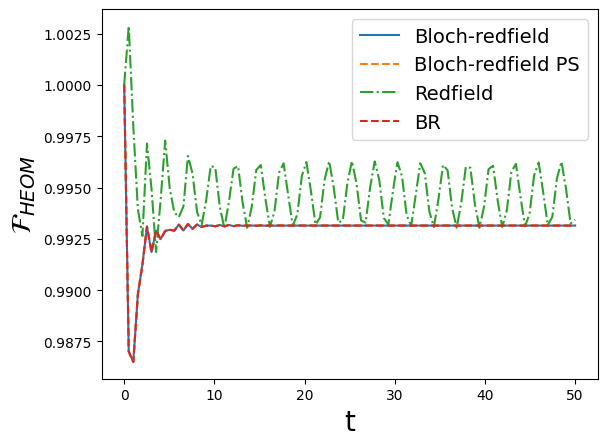

In [43]:
plot_fidelities(results,H,times)